This demo requires some extra global dependencies
- HCubature
- FastGaussQuadrature

In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

In [5]:
using ForneyLab
using BenchmarkTools
using Random
using CairoMakie

import ReactiveMP

In [4]:
include("fl_gcv/GCV.jl")

Main.GCV

In [37]:
ForneyLab.@symmetrical function ForneyLab.prod!(x::ProbabilityDistribution{Univariate, Function},
               y::ProbabilityDistribution{Univariate, F1},
               z::ProbabilityDistribution{Univariate, GaussianMeanVariance}=ProbabilityDistribution(Univariate, GaussianMeanVariance, m=0.0,v=1.0)) where F1<:Gaussian

    p = 20
    dist_y = convert(ProbabilityDistribution{Univariate, GaussianMeanVariance},y)
    
    left = ReactiveMP.NormalMeanVariance(ForneyLab.unsafeMean(dist_y), ForneyLab.unsafeVar(dist_y))
    
    mean, variance = ReactiveMP.approximate_meancov(ReactiveMP.ghcubature(p), (z) -> exp(logPdf(x, z)), left)
    
    z.params[:m] = mean
    z.params[:v] = variance
    
    return z
    
#     g(k) = exp(x.params[:log_pdf](k))
#     normalization_constant = GCV.quadrature(g,dist_y,p)
#     t(k) = k*g(k)/normalization_constant
#     mean = GCV.quadrature(t,dist_y,p)
#     s(k) = (k-mean)^2*g(k)/normalization_constant
#     var = GCV.quadrature(s,dist_y,p)

#     z.params[:m] = mean
#     z.params[:v] = var

#     return z
end

In [38]:
import Distributions

In [39]:
params = let 
    
    seed = 43
    
    n    = 100
    τ_z  = 1.0
    τ_y  = 0.1
    
    κ = 1.0
    ω = 0.0

    @strdict seed n τ_z τ_y κ ω
end;

In [40]:
z, s, y = generate_data(HGFModel(), params);

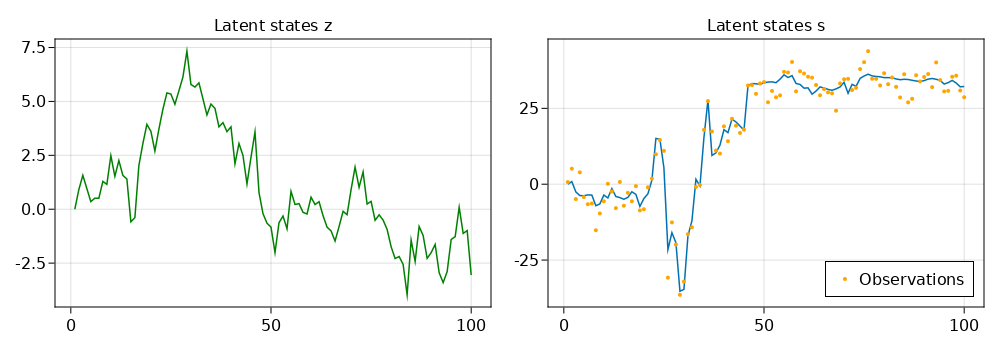

In [41]:
let 
    f = Figure(resolution = (1000, 350))
    
    range = 1:length(z)
    
    ax1 = Axis(f[1, 1], title = "Latent states z")
    ax2 = Axis(f[1, 2], title = "Latent states s")
    
    lines!(ax1, range, z, color = :green)
    
    lines!(ax2, range, s)
    scatter!(ax2, range, y, label = "Observations", markersize = 4, color = :orange)
    
    axislegend(ax2, position = :rb)
    
    f
end

In [42]:
import .GCV: ruleMGaussianControlledVarianceGGDDD, ruleMGaussianMeanPrecisionEGD
import .GCV: ruleSVBGaussianControlledVarianceOutNGDDD, ruleSVBGaussianMeanPrecisionMEND
import .GCV: ruleSVBGaussianControlledVarianceXGNDDD, ruleSVBGaussianControlledVarianceZDNDD
import .GCV: ruleSVBGaussianControlledVarianceXGNDDD
import .GCV: GaussianControlledVariance

In [43]:
g = FactorGraph()

model_τ_z = params["τ_z"]
model_τ_y = params["τ_y"]
model_κ = params["κ"]
model_ω = params["ω"]

@RV zv_min_mean
@RV zv_min_prec

placeholder(zv_min_mean, :zv_min_mean)
placeholder(zv_min_prec, :zv_min_prec)

@RV sv_min_mean
@RV sv_min_prec

placeholder(sv_min_mean, :sv_min_mean)
placeholder(sv_min_prec, :sv_min_prec)

@RV zv_min ~ GaussianMeanPrecision(zv_min_mean, zv_min_prec)
@RV sv_min ~ GaussianMeanPrecision(sv_min_mean, sv_min_prec)

@RV zv ~ GaussianMeanPrecision(zv_min, model_τ_z)
@RV sv ~ GaussianControlledVariance(sv_min, zv, model_κ, model_ω)

@RV yv ~ GaussianMeanPrecision(sv, model_τ_y)

placeholder(yv, :yv)

Variable(:yv, Edges:
Edge belonging to variable yv: ( gaussianmeanprecision_4.i[out] )----( placeholder_yv.i[out] ).
)

In [44]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization([zv, zv_min], [sv, sv_min], ids=[ :Z, :S ])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

  0.427904 seconds (47.48 k allocations: 26.098 MiB)


freeEnergy (generic function with 1 method)

In [55]:
begin     
    nitr = 10
    
    zv_k_mean = 0.0
    zv_k_prec = inv(5.0)
    
    sv_k_mean = 0.0
    sv_k_prec = inv(5.0)
    
    marginals = Dict{Any, Any}(
        :sv_sv_min => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m = [ 0.0, 0.0 ], v = [ 5.0 0.0; 0.0 5.0 ]),
        :zv => ProbabilityDistribution(Univariate, GaussianMeanPrecision, m = zv_k_mean, w = zv_k_prec),
        :sv => ProbabilityDistribution(Univariate, GaussianMeanPrecision, m = sv_k_mean, w = sv_k_prec)
    )
    
    fe = Array{Float64}(undef, length(y), nitr)
    zm = []
    sm = []
    
    for (i, observation) in enumerate(y)
        
        data = Dict(
            :zv_min_mean => zv_k_mean,
            :zv_min_prec => zv_k_prec,
            :sv_min_mean => sv_k_mean,
            :sv_min_prec => sv_k_prec,
            :yv => observation
        )
        
        for j in 1:nitr
            stepS!(data, marginals)
            stepZ!(data, marginals)
            fe[i, j] = freeEnergy(data, marginals)
        end
        
        push!(zm, marginals[:zv])
        push!(sm, marginals[:sv])
        
        zv_k_mean = ForneyLab.unsafeMean(marginals[:zv])
        zv_k_prec = inv(ForneyLab.unsafeVar(marginals[:zv]))
        sv_k_mean = ForneyLab.unsafeMean(marginals[:sv])
        sv_k_prec = inv(ForneyLab.unsafeVar(marginals[:sv]))
    end
    
end

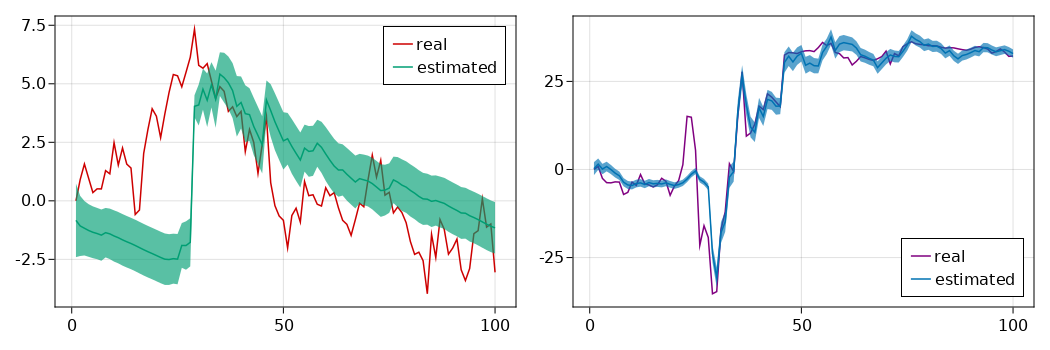

In [56]:
let 
    c = Makie.wong_colors()
    
    @unpack n = params

    f1    = Figure(resolution = (350, 350))
    f2    = Figure(resolution = (350, 350))
    f3    = Figure(resolution = (350, 350))
    grid  = 1:n

    ax1 = Makie.Axis(f1[1, 1])
    ax2 = Makie.Axis(f2[1, 1])
    ax3 = Makie.Axis(f3[1, 1])

    function plot_z(fig)

        lines!(fig, grid, z, color = :red3, label = "real")
        lines!(fig, grid, ForneyLab.unsafeMean.(zm), color = c[3], label = "estimated")
        band!(fig, grid, 
            ForneyLab.unsafeMean.(zm) .- sqrt.(ForneyLab.unsafeVar.(zm)),
            ForneyLab.unsafeMean.(zm) .+ sqrt.(ForneyLab.unsafeVar.(zm)),
            color = (c[3], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :rt)
    end

    function plot_s(fig)

        lines!(fig, grid, s, color = :purple, label = "real")
        lines!(fig, grid, ForneyLab.unsafeMean.(sm), color = c[1], label = "estimated")
        band!(fig, grid, 
            ForneyLab.unsafeMean.(sm) .- sqrt.(ForneyLab.unsafeVar.(sm)),
            ForneyLab.unsafeMean.(sm) .+ sqrt.(ForneyLab.unsafeVar.(sm)),
            color = (c[1], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :rb)
    end

    local rfe = vec(sum(fe, dims = 1))

    function plot_fe(fig)
        lines!(fig, 1:length(rfe), rfe, linewidth = 2, label = "Bethe Free Energy")
        axislegend(fig, labelsize = 16, position = :rb)
    end

    plot_z(ax1)
    plot_s(ax2)
    plot_fe(ax3)

    @saveplot f1 "hgf_inference_z_fl"
    @saveplot f2 "hgf_inference_s_fl"
    @saveplot f3 "hgf_inference_fe_fl"

    local af = Figure(resolution = (350 * 3, 350))

    plot_z(Makie.Axis(af[1, 1]))
    plot_s(Makie.Axis(af[1, 2]))
    # plot_fe(Makie.Axis(af[1, 3]))
    
    # @show average_mse(z, zm[range])
    # @show average_mse(s, sm[range])

    af
end